<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input


# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


Mounted at /content/gdrive


In [2]:
# Especificar las rutas al directorio con las imágenes y al fichero con las etiquetas
imgtrain_dir = "/content/train/images/"
imgtrainmask_dir = "/content/train/masks/"
csvtrain_file = "/content/train.csv"

imgtest_dir = "/content/train.csv"
csvtest_file = "/content/test.csv"
# Leer el fichero CSV con las etiquetas
df = pd.read_csv(csvtrain_file, dtype={"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype={"class": "category"})

# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Convertir las etiquetas codificadas en un vector one-hot
class_one_hot = pd.get_dummies(df['class_encoded'], prefix='class')

# Renombrar las columnas del vector one-hot
class_one_hot.columns = ['normal', 'benign', 'malignant']

# Concatenar el DataFrame original con las etiquetas one-hot y la columna 'mask_filename'
df = pd.concat([df[['image_filename', 'mask_filename']], class_one_hot], axis=1)
df


,image_filename,mask_filename,normal,benign,malignant
0,image_003.png,mask_003.png,True,False,False
1,image_004.png,mask_004.png,True,False,False
2,image_008.png,mask_008.png,True,False,False
3,image_012.png,mask_012.png,True,False,False
4,image_016.png,mask_016.png,True,False,False
...,...,...,...,...,...
332,image_399.png,mask_399.png,False,False,True
333,image_400.png,mask_400.png,False,False,True
334,image_416.png,mask_416.png,False,False,True
335,image_419.png,mask_419.png,False,False,True


In [3]:
# Dividir el conjunto en entrenamiento, validación y test (70:15:15)
val_size = int(len(df) * 0.15)
test_size = int(len(df) * 0.15)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 237
Número de ejemplos del conjunto de validación: 50
Número de ejemplos del conjunto de test: 50


In [4]:
archivos = os.listdir(imgtrain_dir)
anchuras = []
alturas = []
for archivo in archivos:
      imagen = Image.open(os.path.join(imgtrain_dir, archivo))
      ancho, alto = imagen.size
      anchuras.append(ancho)
      alturas.append(alto)
media_anchura = sum(anchuras) / len(anchuras)
media_altura = sum(alturas) / len(alturas)

print("Media de anchura:", media_anchura)
print("Media de altura:", media_altura)

Media de anchura: 634.9139465875371
Media de altura: 514.9317507418398


In [26]:
# Dimensiones deseadas de la imagen
img_width, img_height = 244,244
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases
x_col = 'image_filename'      # nombres de las columnas en el fichero CSV
y_col = ['normal', 'benign', 'malignant']  # lista de nombres de las columnas de las etiquetas

def load_and_preprocess_image(image_filename, mask_filename, label_one_hot):
    # Cargar la imagen
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize_with_pad(image, img_width, img_height)
    image = image / 255.0

    # Cargar y procesar la máscara binaria
    mask_path = tf.strings.join([imgtrainmask_dir, mask_filename])
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize_with_pad(mask, img_width, img_height)
    mask = mask / 255.0

    # Asignar colores diferentes a la máscara según la clase
    colors = tf.constant([(0, 255, 0), (255, 0, 0), (0, 0, 255)], dtype=tf.float32)
    colored_mask = tf.gather(colors, tf.argmax(label_one_hot)) * tf.image.grayscale_to_rgb(mask)

    return image, colored_mask

def get_dataset(df):
    image_filenames = df['image_filename'].values
    mask_filenames = df['mask_filename'].values
    colored_masks = df[y_col].values  # Utiliza las mascaras coloreadas como etiquetas
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames, colored_masks))
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

# Crear los conjuntos de datos y preparar los lotes
batch_size = 32
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)

print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')



Número de lotes del conjunto de entrenamiento: 8
Número de lotes del conjunto de validación: 2
Número de lotes del conjunto de test: 2


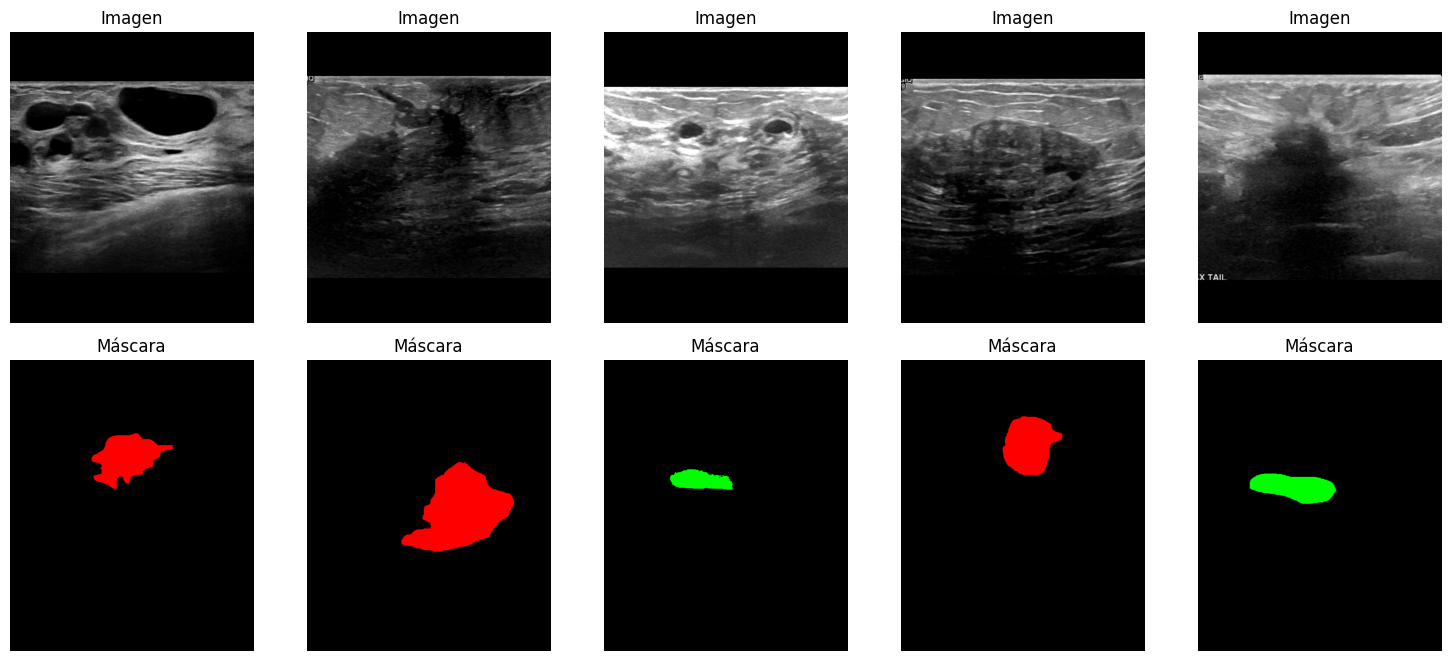

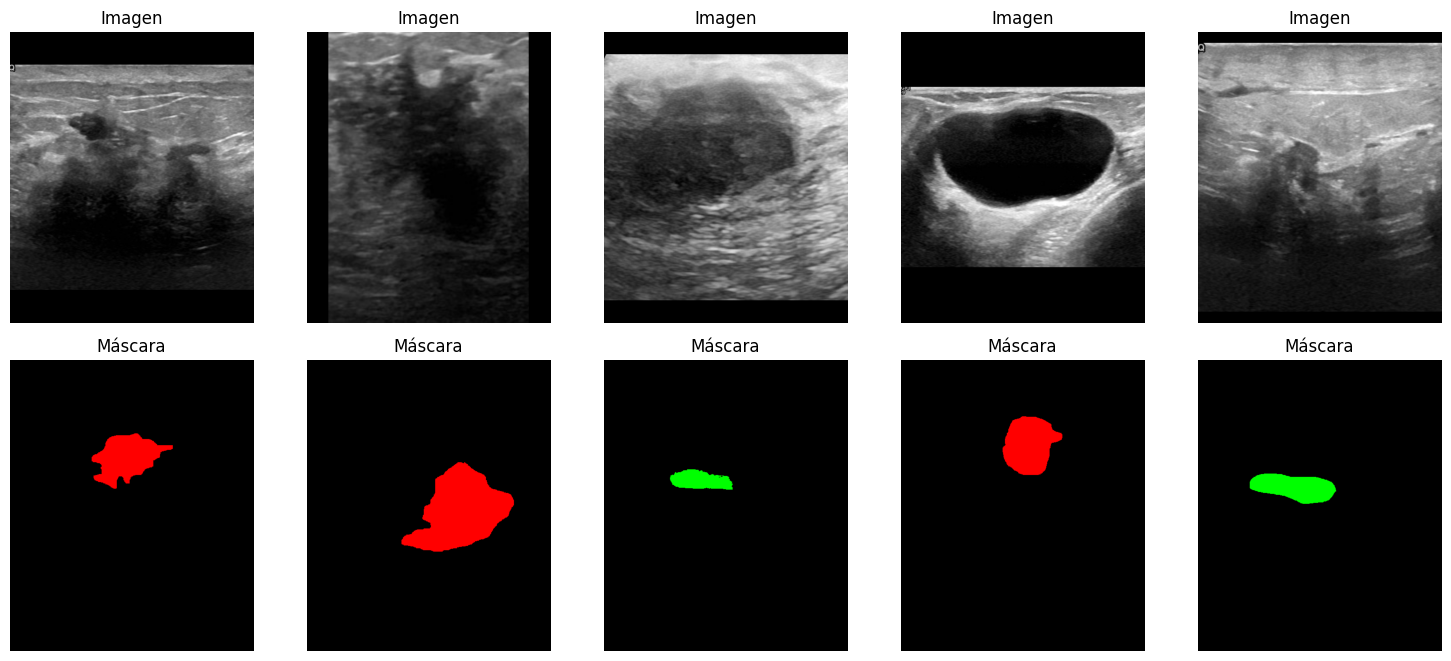

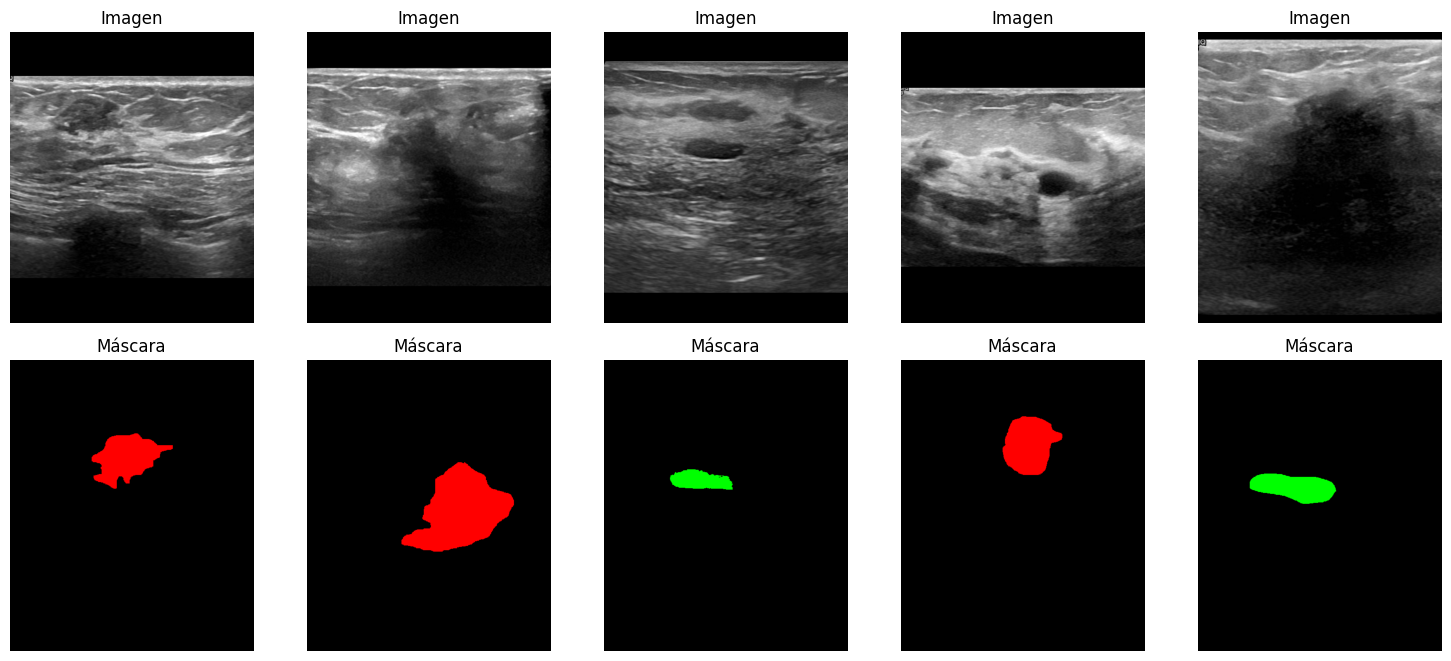

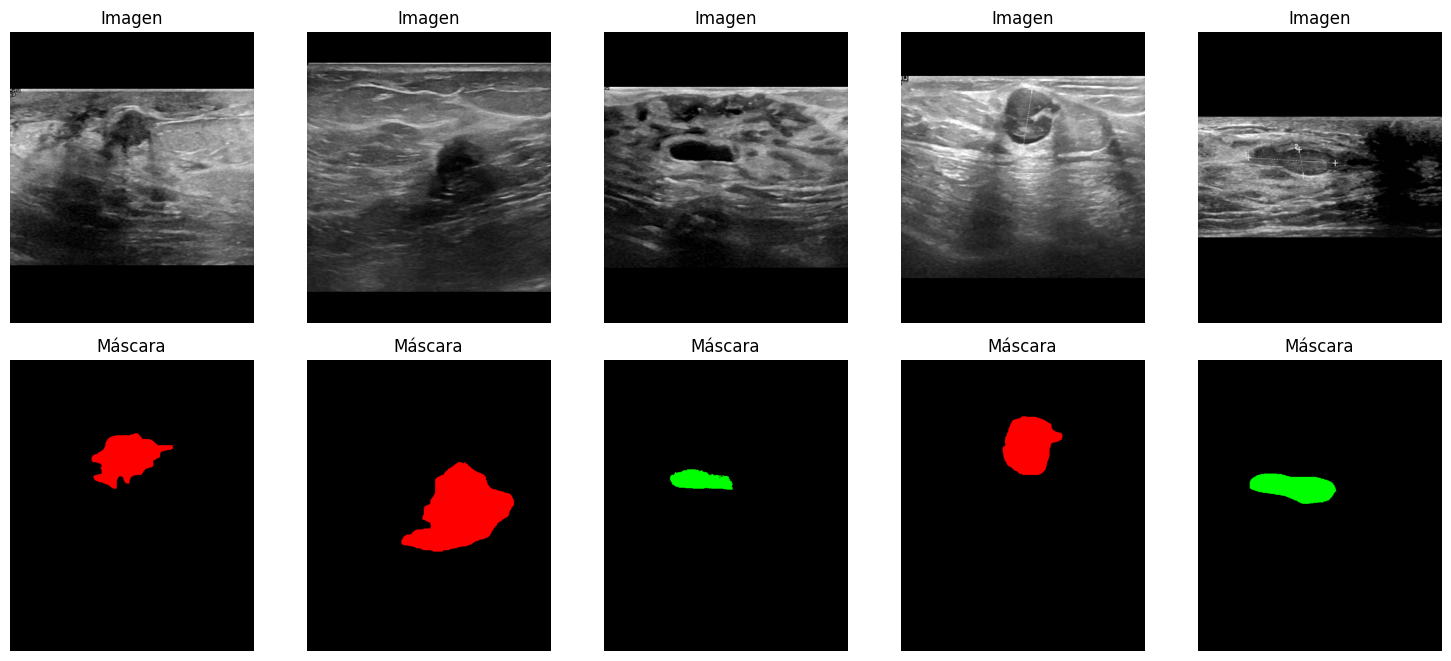

In [21]:
# Definir una función para mostrar imágenes con sus máscaras y etiquetas
def plot_images_with_masks_and_labels(images, masks, labels, label_names, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(3, num_images, i+num_images+1)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Máscara')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Obtener un lote de datos del conjunto de entrenamiento
for images, labels in train_dataset.take(4):
    # Mostrar las primeras 5 imágenes con sus máscaras y etiquetas
    plot_images_with_masks_and_labels(images.numpy(), masks.numpy(), labels.numpy(), label_names=['normal', 'benign', 'malignant'], num_images=5)



In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

def get_model():

  # Cargar la base convolucional del modelo VGG16 pre-entrenado en ImageNet
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

  # Ajustar los parámetros de las nuevas capas del modelo, dejando fijos los parámetros del resto de capas
  for layer in base_model.layers:
      layer.trainable = False   # por defecto, layer.trainable es True

  # Añadir nuevas capas a continuación de la base convolucional, para resolver la tarea de aprendizaje
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)

  # Añadir una última capa completamente conectada con 3 neuronas para obtener la salida de la red (una para cada clase)
  predictions = Dense(3, activation='softmax')(x)  # Cambia el número de neuronas a 3

  # Crear el modelo final e imprimir su representacion en modo texto
  model = Model(inputs=[base_model.input], outputs=[predictions])
  model.summary()

  return model


# Definir el tamaño de entrada y el número de clases
input_shape = (img_width, img_height, n_channels)
num_classes = 3  # Normal, Benigno, Maligno

# Crear el modelo
model = get_model()

# Definir la métrica F1
def f1_metric(y_true, y_pred):
    y_true_int = tf.argmax(y_true, axis=1)
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.cast(y_true_int, tf.float32)
    y_pred_int = tf.cast(y_pred_int, tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true_int, 1), tf.equal(y_pred_int, 1)), tf.float32))
    false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true_int, 0), tf.equal(y_pred_int, 1)), tf.float32))
    false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true_int, 1), tf.equal(y_pred_int, 0)), tf.float32))

    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    return f1

# Configurar el proceso de aprendizaje
opt = Adam(learning_rate=0.001)                 # optimizador Adam
model.compile(loss='categorical_crossentropy',  # función de pérdida para problemas de clasificación multi-clase
              optimizer=opt,
              metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0   

In [32]:
epochs = 6
history = model.fit(train_dataset, epochs=epochs, verbose=2, validation_data=val_dataset)

Epoch 1/6


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 244, 244, 3) and (None, 3) are incompatible


In [ ]:
test_loss, test_accuracy, test_f1 = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_acc: %.4f, test_f1: %.4f" % (test_loss, test_accuracy, test_f1))

2/2 - 13s - loss: 1.1074 - accuracy: 0.5000 - f1_metric: 0.6447 - 13s/epoch - 6s/step
test_loss: 1.1074, test_acc: 0.5000, test_f1: 0.6447


In [ ]:
# Directorio donde se encuentran las imágenes de prueba
test_images_dir = 'test/images/'

# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(test_images_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})

# Crear columnas para 'normal', 'benign' y 'malignant' con valores iniciales de 0
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

# Iterar sobre cada imagen de prueba
for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(test_images_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    # Realizar la predicción
    prediction = very_simple_alexnet_model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    # Actualizar las columnas correspondientes según la predicción
    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

# Ordenar el DataFrame por el nombre del archivo de imagen
predictions_df = predictions_df.sort_values(by='image_filename')

# Guardar el DataFrame en un archivo CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Imprimir las primeras filas del DataFrame para verificar
print(predictions_df.head())


1/1 [==============================] - 0s 366ms/step
    image_filename  normal  benign  malignant
99   image_005.png       0       1          0
71   image_006.png       0       1          0
63   image_007.png       0       1          0
96   image_009.png       0       1          0
110  image_010.png       0       1          0
